# **Telco Customer Churn Prediction**


*Fábio Chacon (April 2020)*

&nbsp;

---

## Table of Contents

- <b><a href="#1">1.0 Connecting to IBM Db2 Database</a></b>
- <b><a href='#2'>2.0 About the Dataset</a></b>
- <b><a href='#3'>3.0 Dataset Overview</a></b>
  - <a href='#3.1'>3.1 Loading the Data</a>
  - <a href='#3.2'>3.2 Checking missing values</a>
  - <a href='#3.3'>3.3 Preliminary Preprocessing</a>
- <b><a href='#4'>4.0 Exploring the Data</a></b>
   - <a href='#4.1'>4.1 Overall Customer Attrition</a>
   - <a href='#4.2'>4.2 Customer Attrition, by Gender</a>
   - <a href='#4.3'>4.3 Attrition of Senior Citizens</a>
   - <a href='#4.4'>4.4 Attrition of married and unmarried customers</a>
   - <a href='#4.5'>4.5 Attrition of Customers with and without dependents</a>
   - <a href='#4.6'>4.6 Services Contracted by Customers</a>
    - <a href='#4.6.1'>4.6.1 Internet Sevices</a>
    - <a href='#4.6.2'>4.6.2 Phone Services</a>
    - <a href='#4.6.3'>4.6.3 Additional Services</a>
   - <a href='#4.7'>4.7 Contract type and Payment Method</a>
   - <a href='#4.8'>4.8 Tenure of Customers</a>
   - <a href='#4.9'>4.9 Monthly Charges Distribution</a>
- <b><a href='#5.0'>5.0 Data Pre-processig</a></b>
    - <a href='#5.1'>5.1 Enconding class labels</a>
    - <a href='#5.2'>5.2 One-hot encoding categorical features</a>
    - <a href='#5.3'>5.3 Creating DataFrame for numerical features</a>
    - <a href='#5.4'>5.4 Concatenating DataFrames</a>
    - <a href='#5.5'>5.5 Loading the data as numpy arrays</a>
- <b><a href='#6.0'>6.0 Model Fitting</a></b>
    - <a href='#6.1'>6.1 Feature Selection</a>
    - <a href='#6.2'>6.2 Tree-based Models</a>
      - <a href='#6.2.1'>6.2.1 Random Forest</a>
      - <a href='#6.2.2'>6.2.2 XGBoost</a>
      - <a href='#6.2.3'>6.2.3 LightGBM</a>
      - <a href='#6.2.4'>6.2.4 Catboost</a>
    - <a href='#6.3'>6.3 Testing other classification algorithms</a>
      - <a href='#6.3.1'>6.3.1 KNeighbors</a>
      - <a href='#6.3.2'>6.3.2 SVM</a>
      - <a href='#6.3.3'>6.3.3 Logistic Regression</a>
      - <a href='#6.3.4'>6.3.4 Naive Bayes</a>
- <b><a href='#7.0'>7.0 Model Evaluation and Results</a></b>
    - <a href='#7.1'>7.1 Table of Scores</a>
    - <a href='#7.2'>7.2 Comparing Performances</a>
    - <a href='#7.3'>7.3 Confusion Matrix</a>
    - <a href='#7.4'>7.4 ROC Curves</a>
- <b><a href='#8.0'>8.0 Dealing with Class Imbalance</a></b>
    - <a href='#8.1'>8.1 Oversampling with SMOTE</a>
    - <a href='#8.2'>8.2 Oversampling with BorderlineSMOTE</a>
    - <a href='#8.3'>8.3 Oversampling with SVMSMOTE</a>
    - <a href='#8.4'>8.4 Evaluation</a>


---

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ibm_db, ibm_db_dbi
%matplotlib inline

plt.style.use('seaborn-white')

# Imports for tree-based algorithms
import catboost as cb
import xgboost as xgb
import lightgbm as lbg
from sklearn.ensemble import RandomForestClassifier

# Imports for other ML algorithms
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

# Sklearn Imports for model evaluation
from sklearn.metrics import (plot_precision_recall_curve,
                             roc_auc_score,
                             balanced_accuracy_score,
                             plot_confusion_matrix,
                             plot_roc_curve,
                             f1_score, recall_score, 
                             precision_score,
                             accuracy_score,
                             classification_report)

# Imblear imports
from imblearn.over_sampling import (SMOTE, 
                                    BorderlineSMOTE, 
                                    SVMSMOTE)

from imblearn.pipeline import make_pipeline

# For label encoding
from sklearn.preprocessing import LabelEncoder

# Import for spliting the dataset
from sklearn.model_selection import train_test_split

# Imports for model selection
from sklearn.model_selection import (cross_val_score,
                                     cross_validate,
                                     StratifiedKFold,
                                     RepeatedStratifiedKFold,
                                     GridSearchCV)

# For scaling the data
from sklearn.preprocessing import StandardScaler

# For feature selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# <a id="1">1.0 Connecting to IBM Db2 Database</a>

In [ ]:
dsn_hostname = "---" 
dsn_uid = "---"       
dsn_pwd = "---"      
dsn_driver = "{IBM DB2 ODBC DRIVER}"
dsn_database = "BLUDB"            
dsn_port = "50000"               
dsn_protocol = "TCPIP"            

dsn = (
    "DRIVER={0};"
    "DATABASE={1};"
    "HOSTNAME={2};"
    "PORT={3};"
    "PROTOCOL={4};"
    "UID={5};"
    "PWD={6};").format(dsn_driver, dsn_database, dsn_hostname, dsn_port, dsn_protocol, dsn_uid, dsn_pwd)

try:
    conn = ibm_db.connect(dsn, "", "")
    print ("Connected to database: ", dsn_database, "as user: ", dsn_uid, "on host: ", dsn_hostname)

except:
    print ("Unable to connect: ", ibm_db.conn_errormsg() )

# <a id='2'>2.0 About the Dataset</a>


This dataset is about customer churn. Customer churn, also known as costumer attrition, is defined as the loss of custumers or clients by a company. The dataset contains 7043 observations and 21 columns. Below is a description of each column in the dataset.

&nbsp;


| Column          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| customerID     | ID of a Costumer                                                                      |
| Gender         | The Gender of a costumer                                                              |
| SeniorCitizen  | Whether the customer is a senior citizen or not                                       |
| Partner        | Whether the customer has a partner or not (Yes, No)                                   |
| Dependents       | Whether the customer has dependents or not (Yes, No)                                |
| tenure           | Number of months the customer has stayed with the company                           |             
| PhoneService     | Whether the customer has a phone service or not (Yes, No)                           |
| MultipleLines    | Whether the customer has multiple lines or not (Yes, No, No phone service)          |
| InternetService  | Customer’s internet service provider (DSL, Fiber optic, No                          |
| OnlineSecurity   |   Whether the customer has online security or not (Yes, No, No internet service)    |
| OnlineBackup     |   Whether the customer has online backup or not (Yes, No, No internet service)      |
| DeviceProtection | Whether the customer has device protection or not (Yes, No, No internet service)    |            
| TechSupport      |  Whether the customer has tech support or not (Yes, No, No internet service)        |               
| StreamingTV      |  Whether the customer has streaming TV or not (Yes, No, No internet service)        |               
| StreamingMovies  |  Whether the customer has streaming movies or not (Yes, No, No internet service)    |               
| Contract         |  The contract term of the customer (Month-to-month, One year, Two year)             |      
| PaperlessBilling |  Whether the customer has paperless billing or not (Yes, No)                        |
|PaymentMethod     |  The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))                                                                                         |
| MonthlyCharges   |  The amount charged to the customer monthly                                          |
| TotalCharges     |  The total amount charged to the customer                                            |             
| Churn            |  Whether the customer churned or not (Yes or No)                                     |


# <a id='3'>3.0 Dataset Overview</a>

## <a id='3.1'>3.1 Loading the Data</a>

In [0]:
pconn = ibm_db_dbi.Connection(conn)
data = pd.read_sql("SELECT * FROM TELCO_CUSTOMER_CHURN", pconn)

In [0]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,"1,889.50",No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,"1,840.75",No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [0]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## <a id='3.2'>3.2 Checking missing values</a>

In [0]:
print("Missing values along rows: \n\n{} \n\nMissing values along columns:\n\n{}".format(data.isnull().sum(axis=1), 
                                                                                         data.isnull().sum(axis=0)))

Missing values along rows: 

0       0
1       0
2       0
3       0
4       0
       ..
7038    0
7039    0
7040    0
7041    0
7042    0
Length: 7043, dtype: int64 

Missing values along columns:

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


There are 11 missing values in the TotalCharges variable.

In [0]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,"7,043.00","7,043.00","7,043.00","7,032.00"
mean,0.16,32.37,64.76,"2,283.30"
std,0.37,24.56,30.09,"2,266.77"
min,0.00,0.00,18.25,18.80
25%,0.00,9.00,35.50,401.45
50%,0.00,29.00,70.35,"1,397.47"
75%,0.00,55.00,89.85,"3,794.74"
max,1.00,72.00,118.75,"8,684.80"


There are 7043 unique observation. The maximum tenure is 72 months.

&nbsp;

## <a id='3.3'>3.3 Preliminary Preprocessing</a>

In [0]:
# Drops rows with missing values
data.dropna(axis=0, inplace=True)

# Drops "customerID" column.
data.drop("customerID", axis=1, inplace=True)

# Replacing numerical encoding in SeniorCitizen variable
data['SeniorCitizen'] = data[['SeniorCitizen']].replace({0: "No", 1: "Yes"})

# Divide tenure into categories
def tenure_to_cat(x):
    if x in range(0, 12):
        return "0-11 months"
    elif x in range(12, 24):
        return "12-23 months"
    elif x in range(24, 36):
        return "24-35 months" 
    elif x in range(36, 48):
        return "36-47 months"
    elif x in range(48, 60):
        return "48-59 months"
    elif x in range(60, 73):
        return "60-72 months"

# Include new column to main dataframe
df = data['tenure'].apply(tenure_to_cat)
data.insert(data.columns.size-1, "tenure_time", df)

# <a id='4'>4.0 Exploring the Data</a>





## <a id='4.1'>4.1 Overall Customer Attrition</a>

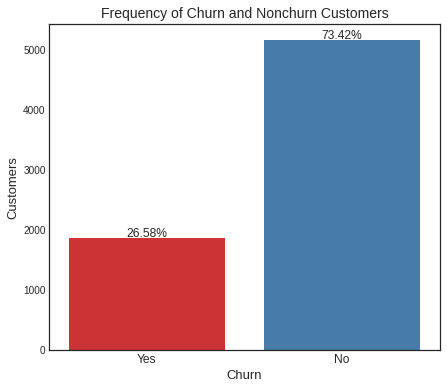

In [0]:
plt.figure(figsize=(7, 6))
churn_count = data["Churn"].value_counts()
g = sns.barplot(x=churn_count.index[::-1], y=churn_count.values[::-1], palette="Set1")
total = churn_count.sum()
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.title("Frequency of Churn and Nonchurn Customers", size=14)
plt.ylabel("Customers", size=13)
plt.xlabel("Churn", size=13)
plt.xticks(fontsize=12)
plt.show()

The above plot clearly shows a class imbalance in the dataset, with more than 70% of observations being of customers who didn't churn. A machine learning model trained on this dataset, will probably be biased towards the majority class. 

## <a id='4.2'>4.2 Customer Attrition, by Gender</a>

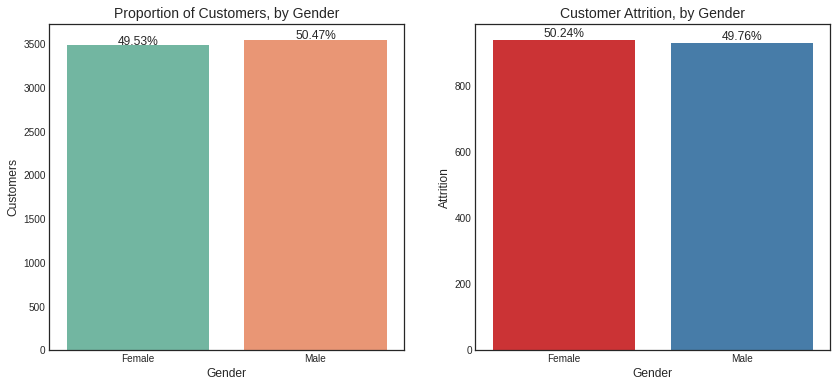

In [0]:
df_gender = data.groupby('gender')['Churn'].value_counts().reset_index(name='Customers')
df_gender_churn = df_gender[df_gender['Churn']=='Yes']

plt.figure(figsize=(14, 6))
plt.subplot(121)
g1 = sns.countplot(x='gender', data=data[['gender']], palette='Set2')
total = data['gender'].value_counts().sum()
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.title("Proportion of Customers, by Gender", size=14)
plt.ylabel("Customers", size=12)
plt.xlabel("Gender", size=12)

plt.subplot(122)
g2 = sns.barplot(x='gender', y='Customers', data=df_gender_churn, palette="Set1")
total = df_gender_churn.Customers.sum()
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.title("Customer Attrition, by Gender", size=14)
plt.ylabel("Attrition", size=12)
plt.xlabel("Gender", size=12)
plt.show()

## <a id='4.3'>4.3 Attrition of Senior Citizens</a>

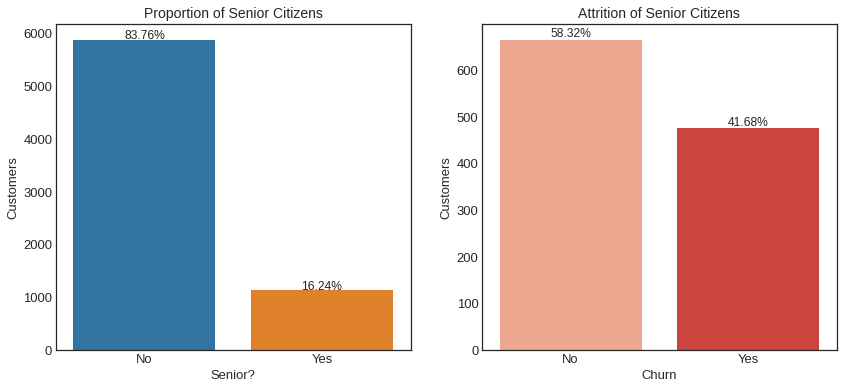

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

df_senior = data.groupby(['SeniorCitizen'])['Churn'].value_counts().reset_index(name='Customers')
senior_count = data[["SeniorCitizen"]]
df_senior_churn = df_senior[df_senior['SeniorCitizen']=='Yes']

g1 = sns.countplot(x='SeniorCitizen', data=senior_count, ax=ax1)
total = senior_count['SeniorCitizen'].value_counts().sum()
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
           height+5,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
ax1.set_ylabel("Customers", size=13)
ax1.set_xlabel("Senior?", size=13)
ax1.tick_params(labelsize=13)
ax1.set_title("Proportion of Senior Citizens", size=14)

g2 = sns.barplot(x='Churn', y='Customers', data=df_senior_churn, palette="Reds", ax=ax2)
total = df_senior_churn.Customers.sum()
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height+5,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
ax2.set_ylabel("Customers", size=13)
ax2.set_xlabel("Churn", size=13)
ax2.tick_params(labelsize=13)
ax2.set_title("Attrition of Senior Citizens", size=14)
plt.show()

Senior citizens comprise roughly 17% of customers (more than 1000 observations). However, there was a high attrition rate of elderly customers. In fact, almost half of them canceled the contract with the company.

## <a id='4.4'>4.4 Attrition of married and unmarried customers</a>

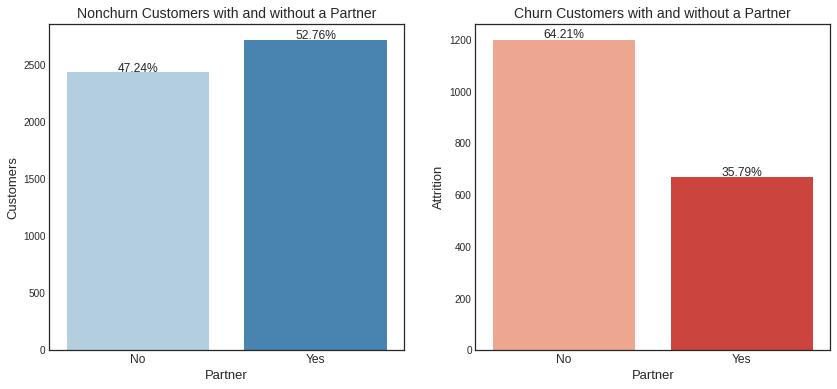

In [0]:
df_partner = data.groupby(['Partner'])['Churn'].value_counts().reset_index(name='Customers')
df_partner_nonchurn = df_partner.query("Churn=='No'")
df_partner_churn = df_partner.query("Churn=='Yes'")

plt.figure(figsize=(14, 6))

plt.subplot(121)
g1 = sns.barplot(x="Partner", y="Customers", data=df_partner_nonchurn, palette="Blues")
total = df_partner_nonchurn.Customers.sum()
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
           height+5,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.xticks(size=12)
plt.xlabel("Partner", size=13)
plt.ylabel("Customers", size=13)
plt.title("Nonchurn Customers with and without a Partner", size=14)
    
plt.subplot(122)
g2 = sns.barplot(x="Partner", y="Customers", data=df_partner_churn, palette="Reds")
total = df_partner_churn.Customers.sum()
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height+5,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.xticks(size=12)
plt.xlabel("Partner", size=13)
plt.ylabel("Attrition", size=13)
plt.title('Churn Customers with and without a Partner', size=14)

plt.show()

## <a id='4.5'>4.5 Attrion of Customers with and without dependents</a>

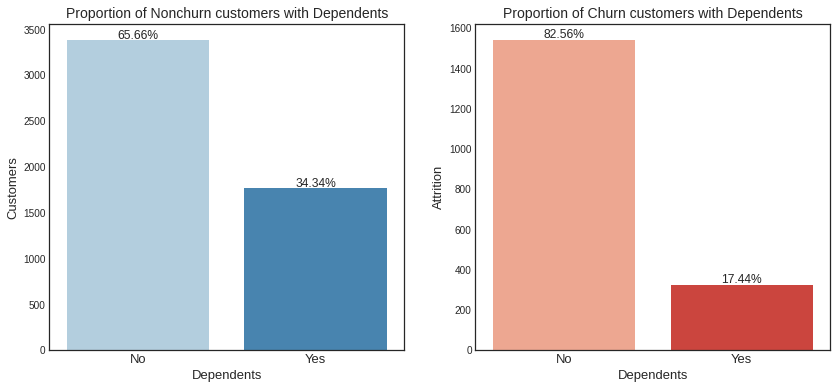

In [0]:
plt.figure(figsize=(14, 6))
df_dependets = data.groupby("Dependents")['Churn'].value_counts().reset_index(name='Customers')
df_dependets_churn = df_dependets.loc[df_dependets['Churn']=='Yes']
df_dependets_nonchurn = df_dependets.loc[df_dependets['Churn']=='No']

plt.subplot(121)
g1 = sns.barplot(x='Dependents', y='Customers', data=df_dependets_nonchurn, palette="Blues")
total = df_dependets_nonchurn.Customers.sum()
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.xticks(fontsize=13)
plt.ylabel("Customers", fontsize=13)
plt.xlabel("Dependents", fontsize=13)
plt.title("Proportion of Nonchurn customers with Dependents", size=14)

plt.subplot(122)
g2 = sns.barplot(x='Dependents', y='Customers', data=df_dependets_churn, palette="Reds")
total = df_dependets_churn.Customers.sum()
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.xticks(fontsize=13)
plt.xlabel("Dependents", fontsize=13)
plt.ylabel("Attrition", fontsize=13)
plt.title("Proportion of Churn customers with Dependents", size=14)
plt.show()

## <a id='4.6'>4.6 Services Contracted by Customers</a> 

### <a id='4.6.1'>4.6.1 Internet Sevices</a>

In [0]:
df_tech_info = data.iloc[:, 5:13]
tech_info_cols = df_tech_info.columns
df_tech_info["Churn"] = data[['Churn']]

df_phone_service = df_tech_info[['PhoneService', 'MultipleLines', 'Churn']]
df_net_service = df_tech_info[['InternetService', 'Churn']]

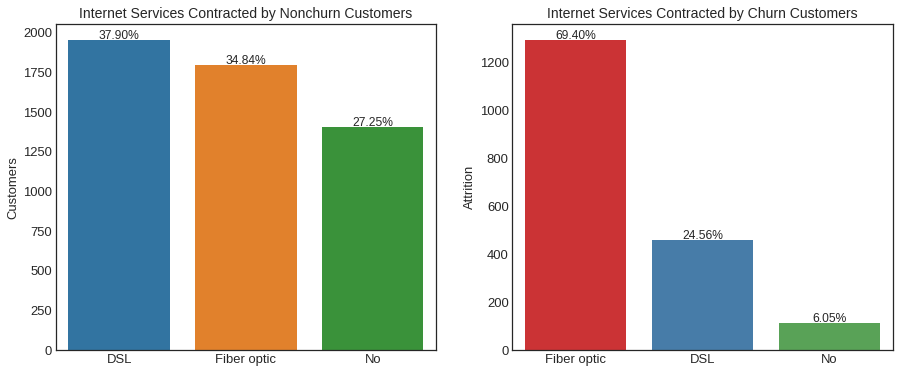

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

df_phone_service = df_tech_info[['PhoneService', 'MultipleLines', 'Churn']]
df_net_service = df_tech_info[['InternetService', 'Churn']]

g1 = sns.countplot(x='InternetService', data=df_net_service.query("Churn=='No'"), ax=ax1)
total = df_net_service.loc[df_net_service['Churn']=='No']["Churn"].value_counts()[0]
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
           height+5,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
ax1.set_title("Internet Services Contracted by Nonchurn Customers", fontsize=14)
ax1.set_xlabel("")
ax1.set_ylabel("Customers", size=13)
ax1.tick_params(labelsize=13)

df_net_service = df_net_service.groupby("InternetService")["Churn"].value_counts()
df_net_churn = df_net_service.loc[:, 'Yes'].reset_index()
df_net_churn = df_net_churn.sort_values(by='Churn', ascending=False)

total = df_net_churn['Churn'].sum()
g2 = sns.barplot(x='InternetService', y='Churn', data=df_net_churn, palette="Set1", ax=ax2)
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height+5,
           '{:1.2f}%'.format(height/total * 100),
            ha="center", fontsize=12)
ax2.set_title("Internet Services Contracted by Churn Customers", fontsize=14)
ax2.set_xlabel("")
ax2.set_ylabel("Attrition", size=13)
ax2.tick_params(labelsize=13)
plt.show()

DSL internet provider was the choice of the majority of nonchurn customers, while fiber optic, of the churn ones. We must be careful not to be mislead by this information, and immediately infer that the choice of fiber optic as internet service, is correlated with the decision of a customer to leave or switch to another company. The left hand side bar graph shows that 35% of nonchurn customers - which corresponds to more than 1500 observations - also chose fiber optic internet provider. We must take other variables into account.

### <a id='4.6.2'>4.6.2 Phone Services</a>

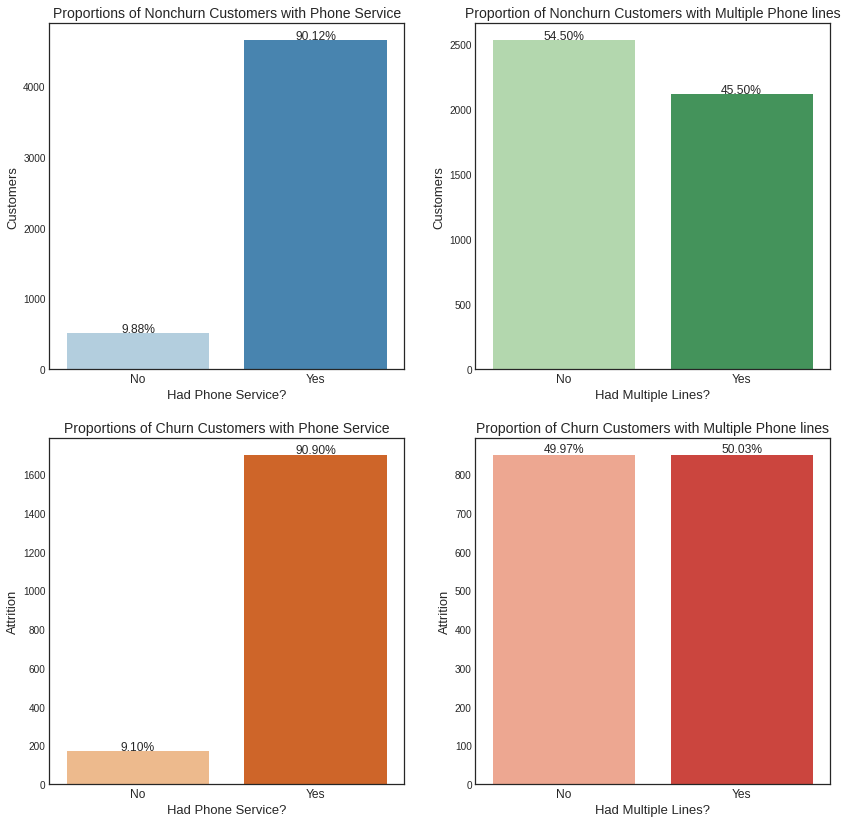

In [0]:
df_phone = df_phone_service.groupby('PhoneService')["Churn"].value_counts().reset_index(name='Customers')
df_phone_churn = df_phone.query("Churn=='Yes'")
df_phone_nonchurn = df_phone.query("Churn=='No'")

plt.figure(figsize=(14, 14))

df_multline = df_phone_service.groupby('MultipleLines')["Churn"].value_counts().reset_index(name='Customers')
df_multline_churn = df_multline.query("(MultipleLines != 'No phone service') & (Churn=='Yes')")
df_multline_nonchurn = df_multline.query("(MultipleLines != 'No phone service') & (Churn=='No')")

plt.subplot(221)
total = df_phone_nonchurn['Customers'].sum()
g1 = sns.barplot(x='PhoneService', y='Customers', data=df_phone_nonchurn, palette='Blues')
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.title("Proportions of Nonchurn Customers with Phone Service", size=14)
plt.xlabel("Had Phone Service?", size=13)
plt.ylabel("Customers", size=13)
plt.xticks(fontsize=12)

plt.subplot(222)
g2 = sns.barplot(x='MultipleLines', y='Customers', data=df_multline_nonchurn, palette='Greens')
total = df_multline_nonchurn['Customers'].sum()
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.title("Proportion of Nonchurn Customers with Multiple Phone lines", size=14)
plt.xlabel("Had Multiple Lines?", size=13)
plt.ylabel("Customers", size=13)
plt.xticks(fontsize=12)

plt.subplot(223)
total = df_phone_churn['Customers'].sum()
g1 = sns.barplot(x='PhoneService', y='Customers', data=df_phone_churn, palette='Oranges')
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.title("Proportions of Churn Customers with Phone Service", size=14)
plt.xlabel("Had Phone Service?", size=13)
plt.ylabel("Attrition", size=13)
plt.xticks(fontsize=12)

plt.subplot(224)
g2 = sns.barplot(x='MultipleLines', y='Customers', data=df_multline_churn, palette='Reds')
total = df_multline_churn['Customers'].sum()
for p in g2.patches:
    height = p.get_height()
    g2.text(p.get_x()+p.get_width()/2.,
           height+8,
           '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=12)
plt.title("Proportion of Churn Customers with Multiple Phone lines", size=14)
plt.xlabel("Had Multiple Lines?", size=13)
plt.ylabel("Attrition", size=13)
plt.xticks(fontsize=12)

plt.show()

### <a id='4.6.3'>4.6.3 Additional Services</a>

In [0]:
df_tech_info.drop(['InternetService', "PhoneService", 'MultipleLines'], axis=1, inplace=True)
df_tech_info = df_tech_info.where(df_tech_info != 'No internet service')

df_tech_churn = df_tech_info.query("Churn=='Yes'")
df_tech_nonchurn =  df_tech_info.query("Churn=='No'")

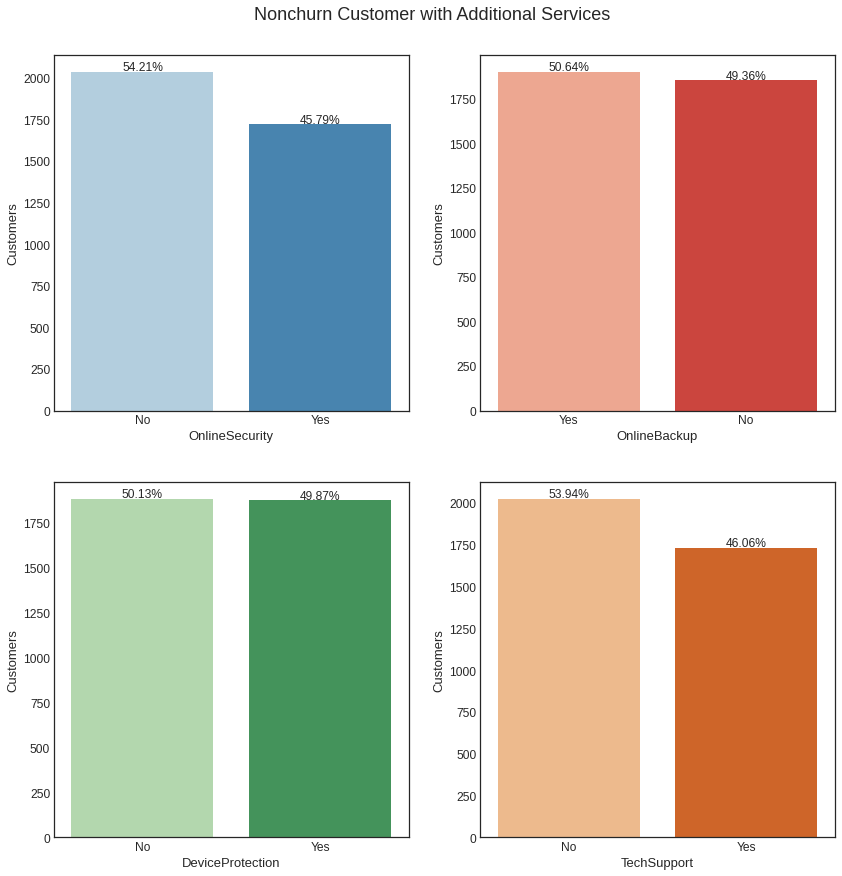

In [0]:
fig, axis = plt.subplots(2, 2, figsize=(14, 13.5))
fig.suptitle('Nonchurn Customer with Additional Services', size=18)
palettes = ["Blues", "Reds", "Greens", "Oranges"]
for ax, col, palette in zip(axis.flatten(), df_tech_nonchurn.columns[:-1], palettes):
    df = df_tech_nonchurn[col].value_counts().reset_index(name='Customers')
    g = sns.barplot(x='index', y='Customers', data=df, palette=palette, ax=ax)
    total = df_tech_nonchurn[col].value_counts().sum()
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
               height+10,
               '{:1.2f}%'.format(height/total*100),
               ha="center", fontsize=12)
        ax.set_ylabel("Customers", size=13)
        ax.set_xlabel(col, size=13)
        ax.tick_params(labelsize=12)

plt.subplots_adjust(top=0.93)
plt.show()

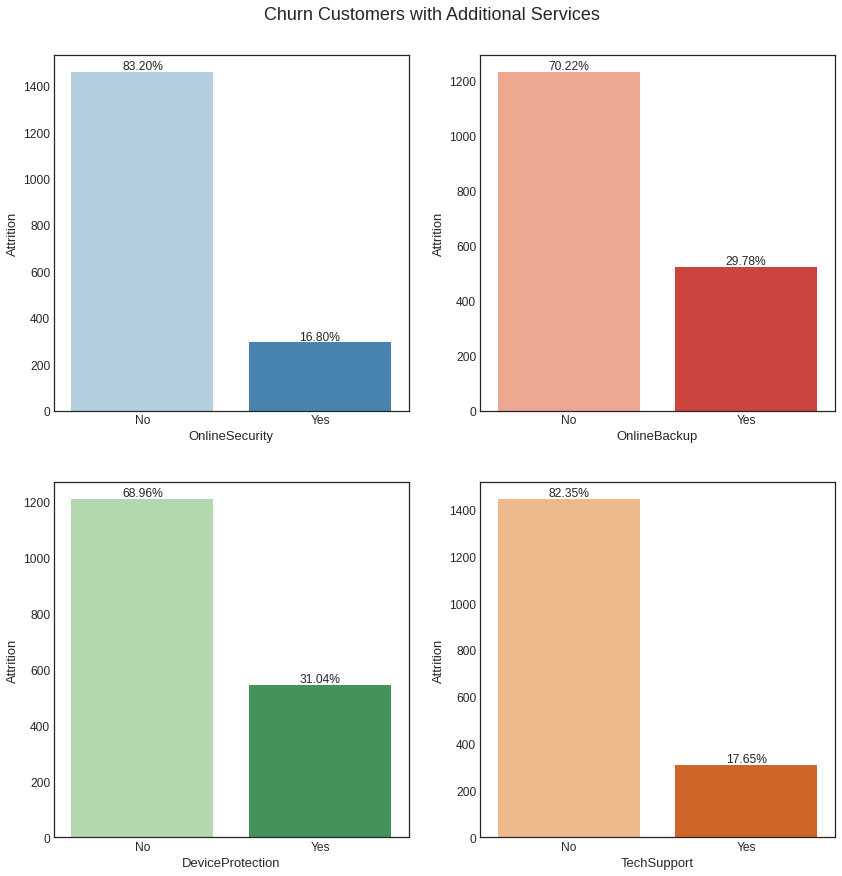

In [0]:
fig, axis = plt.subplots(2, 2, figsize=(14, 13.5))
fig.suptitle('Churn Customers with Additional Services', size=18)
palettes = ["Blues", "Reds", "Greens", "Oranges"]
for ax, col, palette in zip(axis.flatten(), df_tech_churn.columns[:-1], palettes):
    df = df_tech_churn[col].value_counts().reset_index(name='Customers')
    g = sns.barplot(x='index', y='Customers', data=df, palette=palette, ax=ax)
    total = df_tech_churn[col].value_counts().sum()
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x()+p.get_width()/2.,
               height+10,
               '{:1.2f}%'.format(height/total*100),
               ha="center", fontsize=12)
        ax.set_ylabel("Attrition", size=13)
        ax.set_xlabel(col, size=13)
        ax.tick_params(labelsize=12)
plt.subplots_adjust(top=0.93)
plt.show()

## <a id='4.7'>4.7 Contract type and Payment Method</a> 

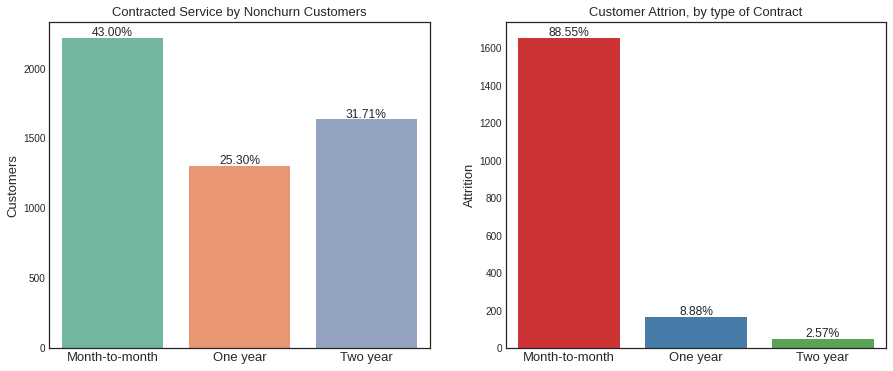

In [0]:
plt.figure(figsize=(15, 6))
df_contract = data.groupby('Contract')['Churn'].value_counts().reset_index(name="Customers")
df_contract_nonchurn = df_contract.loc[df_contract['Churn']=='No']
df_contract_churn = df_contract.loc[df_contract['Churn']=='Yes']

plt.subplot(121)
g = sns.barplot(x='Contract', y='Customers', palette='Set2', data=df_contract_nonchurn)
total = df_contract_nonchurn['Customers'].sum()
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
        height+10,
        '{:1.2f}%'.format(height/total * 100),
         ha="center", fontsize=12)
plt.xlabel(None)
plt.ylabel("Customers", size=13)
plt.xticks(fontsize=13)
plt.title("Contracted Service by Nonchurn Customers", size=13)

plt.subplot(122)
g = sns.barplot(x='Contract', y='Customers', data=df_contract_churn, palette='Set1')
total = df_contract_churn['Customers'].sum()
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
        height+10,
        '{:1.2f}%'.format(height/total * 100),
         ha="center", fontsize=12)   
plt.xlabel(None)
plt.ylabel("Attrition", size=13)
plt.xticks(fontsize=13)
plt.title("Customer Attrion, by type of Contract", size=13)

plt.show()

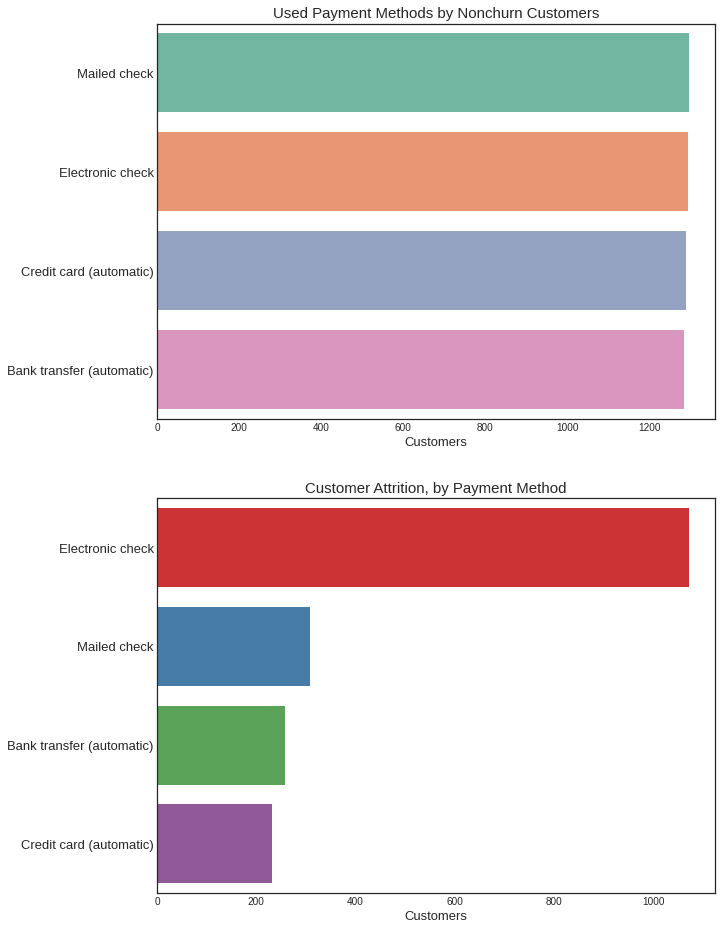

In [0]:
plt.figure(figsize=(10, 16))
df_paymethod = data.groupby("PaymentMethod")['Churn'].value_counts().reset_index(name='Customers')

df_paymethod_nonchurn = df_paymethod.query("Churn=='No'").sort_values(by='Customers', ascending=False)
df_paymethod_churn = df_paymethod.query("Churn=='Yes'").sort_values(by='Customers', ascending=False)

plt.subplot(211)
sns.barplot(x='Customers', y='PaymentMethod', palette='Set2', data=df_paymethod_nonchurn)
plt.ylabel(None)
plt.xlabel("Customers", size=13)
plt.yticks(fontsize=13)
plt.title("Used Payment Methods by Nonchurn Customers", size=15)

plt.subplot(212)
sns.barplot(x='Customers', y="PaymentMethod", palette='Set1', data=df_paymethod_churn)
plt.ylabel(None)
plt.xlabel("Customers", size=13)
plt.yticks(fontsize=13)
plt.title("Customer Attrition, by Payment Method", size=15)
plt.show()

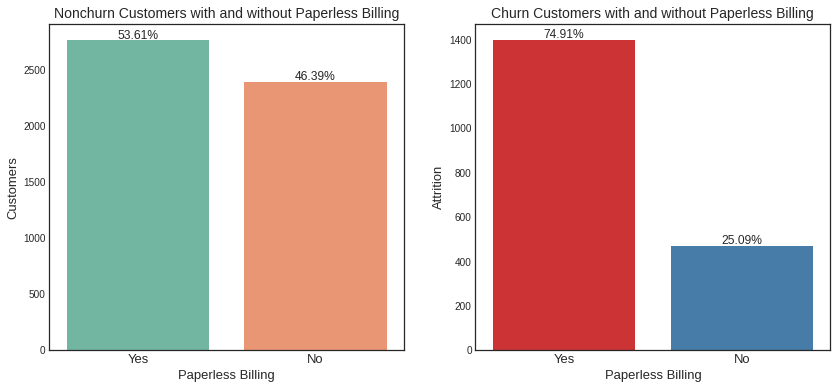

In [0]:
df_contract = data.groupby('PaperlessBilling')["Churn"].value_counts().reset_index(name='Customers')

df_billing_nonchurn = df_contract.query("Churn=='No'").sort_values(by='Customers', ascending=False)
df_billing_churn = df_contract.query("Churn=='Yes'").sort_values(by='Customers', ascending=False)

plt.figure(figsize=(14, 6))
plt.subplot(121)
g = sns.barplot(x='PaperlessBilling', y='Customers', palette='Set2', data=df_billing_nonchurn)
total = df_billing_nonchurn['Customers'].sum()
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
        height+10,
        '{:1.2f}%'.format(height/total*100),
         ha="center", fontsize=12)
plt.ylabel("Customers", size=13)
plt.xlabel("Paperless Billing", size=13)
plt.xticks(fontsize=13)
plt.title("Nonchurn Customers with and without Paperless Billing", size=14)

plt.subplot(122)
g = sns.barplot(x='PaperlessBilling', y='Customers', palette='Set1', data=df_billing_churn)
total = df_billing_churn['Customers'].sum()
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
        height+10,
        '{:1.2f}%'.format(height/total*100),
         ha="center", fontsize=12)
plt.xlabel("Paperless Billing", size=13)
plt.ylabel("Attrition", size=13)
plt.xticks(fontsize=13)
plt.title("Churn Customers with and without Paperless Billing", size=14)
plt.show()

## <a id='4.8'>4.8 Tenure of Customers</a>

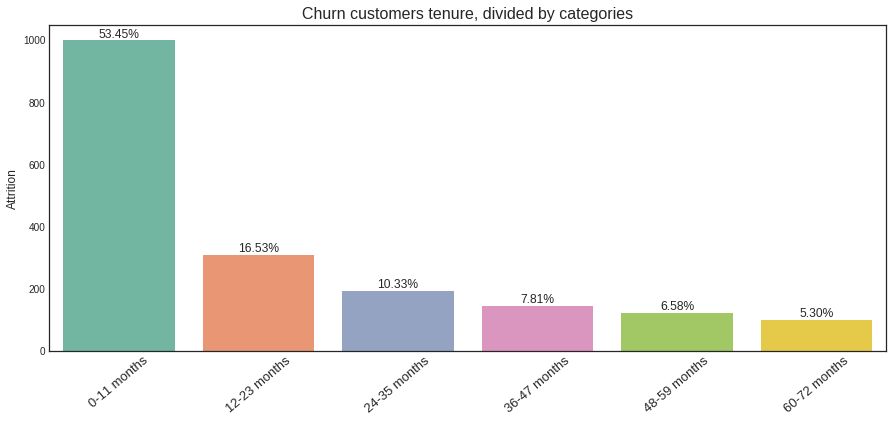

In [0]:
df_tenure = data.groupby('tenure_time')["Churn"].value_counts().reset_index(name="Customers")
df_tenure_churn = df_tenure.query("Churn=='Yes'")
plt.figure(figsize=(15, 6))
g = sns.barplot(x="tenure_time", y='Customers', data=df_tenure_churn, palette="Set2")
total = df_tenure_churn.Customers.sum()
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
        height+10,
        '{:1.2f}%'.format(height/total*100),
         ha="center", fontsize=12)
plt.xticks(rotation=40, size=13)
plt.ylabel("Attrition", size=12)
plt.title("Churn customers tenure, divided by categories", size=16)
plt.xlabel(None)
plt.show()

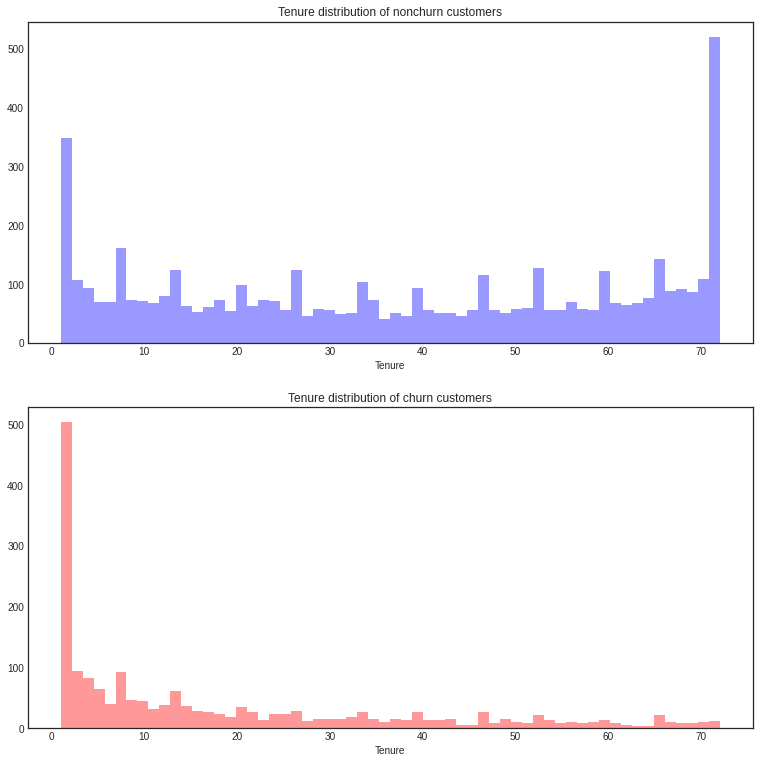

In [0]:
plt.figure(figsize=(13, 13))
plt.subplot(211)
sns.distplot(data.query("Churn=='No'")["tenure"], bins=60, kde=False, color='blue')
plt.title("Tenure distribution of nonchurn customers")
plt.xlabel("Tenure")
plt.subplot(212)
sns.distplot(data.query("Churn=='Yes'")["tenure"], bins=60, kde=False, color='red')
plt.title('Tenure distribution of churn customers')
plt.xlabel("Tenure")
plt.show()

## <a id='4.9'>4.9 Monthly Charges Distribution</a>

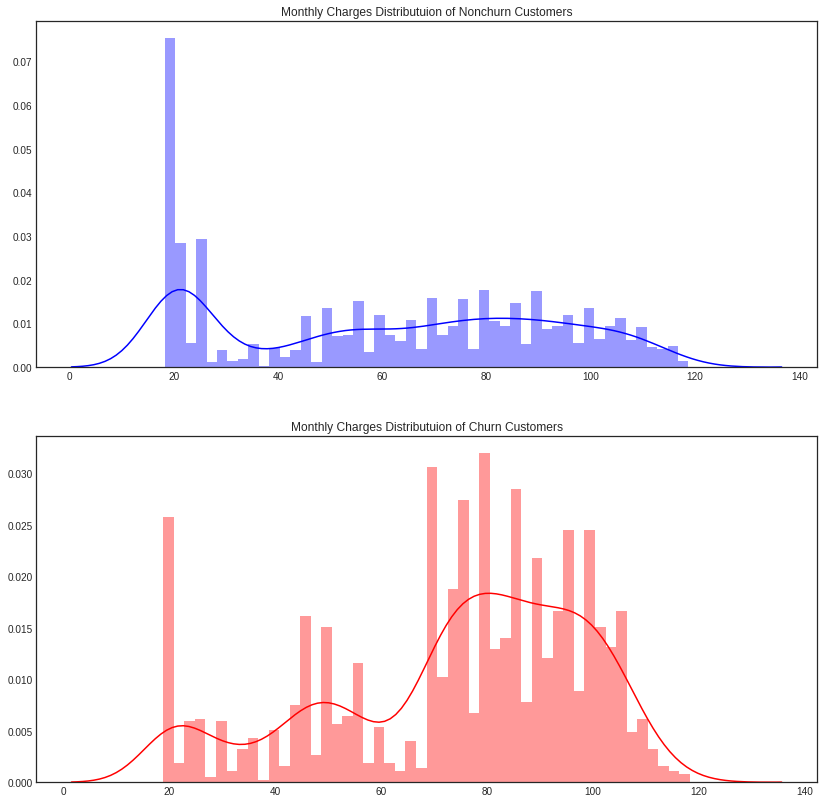

In [0]:
df_charge_nonchurn = data[["MonthlyCharges", 'Churn']].query("Churn=='No'")[['MonthlyCharges']]
df_charge_churn = data[["MonthlyCharges", 'Churn']].query("Churn=='Yes'")[['MonthlyCharges']]

plt.figure(figsize=(14, 14))

plt.subplot(211)
sns.distplot(df_charge_nonchurn , bins=50, kde=True, color='blue')
plt.title("Monthly Charges Distributuion of Nonchurn Customers")

plt.subplot(212)
sns.distplot(df_charge_churn , bins=50, kde=True, color='red')
plt.title("Monthly Charges Distributuion of Churn Customers")

plt.show()

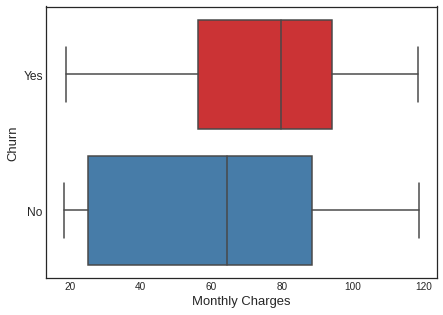

In [0]:
plt.figure(figsize=(7, 5))
sns.boxplot(x='MonthlyCharges', y='Churn', data=data, order=["Yes", "No"], palette="Set1")
plt.xlabel('Monthly Charges', size=13)
plt.ylabel('Churn', size=13)
plt.yticks(size=12)
plt.show()

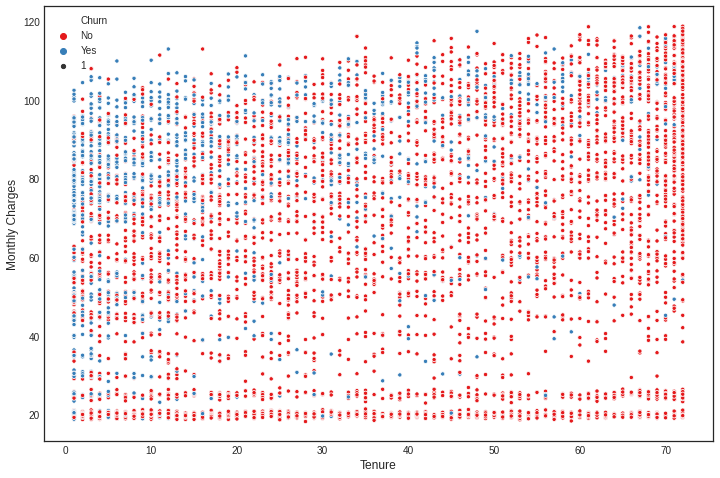

In [0]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='tenure', 
                y='MonthlyCharges', 
                hue="Churn", 
                data=data, 
                size=1,
                palette='Set1')
plt.xlabel("Tenure", size=12)
plt.ylabel("Monthly Charges", size=12)
plt.show()    

# <a id='5.0'>5.0 Data Pre-processig</a>

## <a id='5.1'>5.1 Enconding class labels</a>

In [0]:
lab_encoder = LabelEncoder()
Class_labels = data[['Churn']]
Class_labels = Class_labels.apply(lab_encoder.fit_transform)

## <a id='5.2'>5.2 One-hot encoding categorical features</a>

In [9]:
multiclass_col = data.nunique().drop(["Churn"])[data.nunique() <= 6].index
Feature_multiclass = data[multiclass_col]
Feature_multiclass = pd.get_dummies(Feature_multiclass)
Feature_multiclass.head()

,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_time_0-11 months,tenure_time_12-23 months,tenure_time_24-35 months,tenure_time_36-47 months,tenure_time_48-59 months,tenure_time_60-72 months
0,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0
1,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0
2,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0
3,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0
4,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0


## <a id='5.3'>5.3 Creating DataFrame for numerical features</a>

In [10]:
numeric_col = data.nunique()[data.nunique() > 6].index
Feature_numeric = data[numeric_col]
Feature_numeric.head()

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65


## <a id='5.4'>5.4 Concatenating DataFrames</a>

In [11]:
df_feature = pd.concat([Feature_numeric, Feature_multiclass, Class_labels], axis=1)
df_feature.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_time_0-11 months,tenure_time_12-23 months,tenure_time_24-35 months,tenure_time_36-47 months,tenure_time_48-59 months,tenure_time_60-72 months,Churn
0,1,29.85,29.85,1,0,1,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0
1,34,56.95,1889.50,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0
2,2,53.85,108.15,0,1,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1
3,45,42.30,1840.75,0,1,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0
4,2,70.70,151.65,1,0,1,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1


## <a id='5.5'>5.5 Loading the data as numpy arrays</a>

In [0]:
X_data, y_true = df_feature.iloc[:, :-1].values, df_feature['Churn'].values.astype(int)

In [13]:
print("Proportion of zeros is %.2f%%" % (np.count_nonzero(X_data==0) / X_data.size * 100))

Proportion of zeros is 61.54%


The majority of entries in the data matrix are zeros. We are dealing with a sparse matrix.

# <a id='6.0'>6.0 Model Fitting</a>

In [14]:
# Splitting the data into a training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_true, test_size=.3, 
                                                    random_state=111, stratify=y_true)

# Scaling the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print("Train size: {} | Test size: {}".format(X_train.shape[0], X_test.shape[0]))

Train size: 4922 | Test size: 2110


In [0]:
def val_kfold(model):
    kfold = StratifiedKFold(n_splits=10, random_state=1)
    scores = cross_validate(model, 
                            X_train, y_train, 
                            scoring=['recall', 'roc_auc'], 
                            cv=kfold)
    return scores

def plot_feature_importances(model):
    """
    This function shows feature importances
    for tree-based models.
    """
    plt.figure(figsize=(14, 3.5))
    ft_labels = df_feature.columns[:-1]
    importances = model.feature_importances_
    indices = np.argsort(importances)
    sns.barplot(x=ft_labels[indices], y=importances[indices], palette="Blues")
    plt.title("Feature Importances ({})".format(type(model).__name__), size=12)
    plt.xlim([X_train.shape[1], -1])
    plt.xticks(rotation=90)
    plt.show()

def show_scores(scores):
    scores_recall = scores['test_recall']
    scores_rocauc = scores['test_roc_auc']
    print("CV Recall: %.2f +/- %.3f" % (np.mean(scores_recall), np.std(scores_recall))) 
    print("CV ROC AUC: %.2f +/- %.3f" % (np.mean(scores_rocauc), np.std(scores_rocauc)))

## <a id='6.1'>6.1 Feature Selection</a>

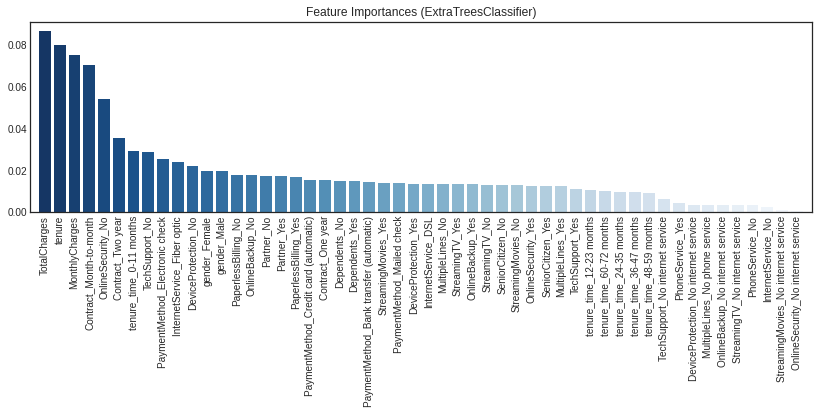

In [17]:
# Feature selection Procedure
clf = ExtraTreesClassifier(n_estimators=50,
                           class_weight='balanced')
clf.fit(X_train, y_train)
plot_feature_importances(clf)
model = SelectFromModel(clf, prefit=True)
X_train, X_test = model.transform(X_train), model.transform(X_test)

## <a id='6.2'>6.2 Tree-based Models</a>

### <a id='6.2.1'>6.2.1 Random Forest</a>

In [18]:
RF_clf = RandomForestClassifier(
    criterion='gini',
    class_weight='balanced',
    n_estimators=100,
    max_depth=7
)

scores = val_kfold(RF_clf)
show_scores(scores)

CV Recall: 0.77 +/- 0.031
CV ROC AUC: 0.84 +/- 0.011


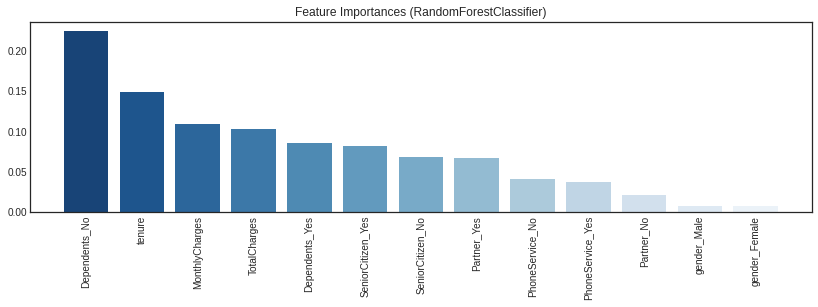

In [19]:
RF_clf.fit(X_train, y_train)
plot_feature_importances(RF_clf)

### <a id='6.2.2'>6.2.2 XGBoost</a>

In [42]:
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    booster='gbtree',
    max_depth=1,
    scale_pos_weight=2,
    colsample_bytree=.9,
    colsample_bylevel=.9,
    n_jobs=-1,
    min_child_weight=15,
    n_estimators=100,
    num_round=200
)
scores = val_kfold(xgb_clf)
show_scores(scores)

CV Recall: 0.74 +/- 0.034
CV ROC AUC: 0.84 +/- 0.012


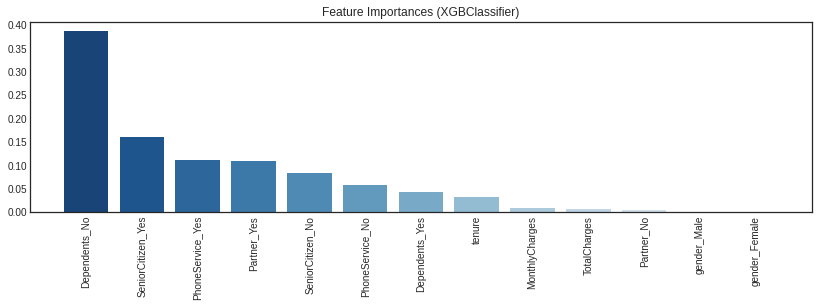

In [43]:
xgb_clf.fit(X_train, y_train)
plot_feature_importances(xgb_clf)

### <a id='6.2.3'>6.2.3 LightGBM</a>

In [44]:
lgb_clf = lbg.LGBMClassifier(
    max_depth=3,
    min_data_in_leaf=15,
    min_child_samples=30,
    scale_pos_weight=2,
    num_leaves=50,
    n_estimators=100
  )

scores = val_kfold(lgb_clf)
show_scores(scores)

CV Recall: 0.71 +/- 0.039
CV ROC AUC: 0.84 +/- 0.014


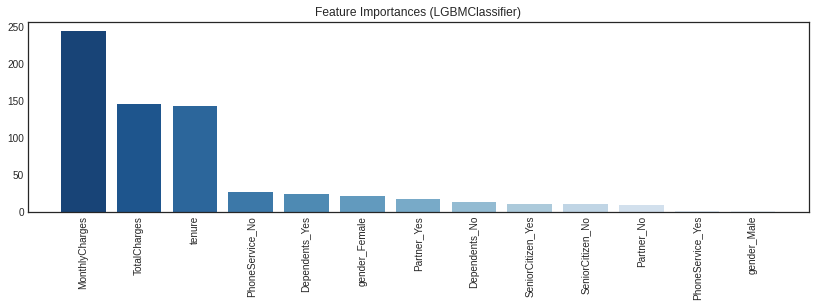

In [45]:
lgb_clf.fit(X_train, y_train)
plot_feature_importances(lgb_clf)

### <a id='6.2.4'>6.2.4 Catboost</a>

In [46]:
cb_clf = cb.CatBoostClassifier(
    random_seed=63,
    depth=3,
    iterations=100,
    learning_rate=0.01,
    l2_leaf_reg=3,
    bagging_temperature=1,
    class_weights=[1, 2],
    verbose=0,
    random_strength=1,
    one_hot_max_size=2
)

scores = val_kfold(cb_clf)
show_scores(scores)

CV Recall: 0.75 +/- 0.043
CV ROC AUC: 0.84 +/- 0.015


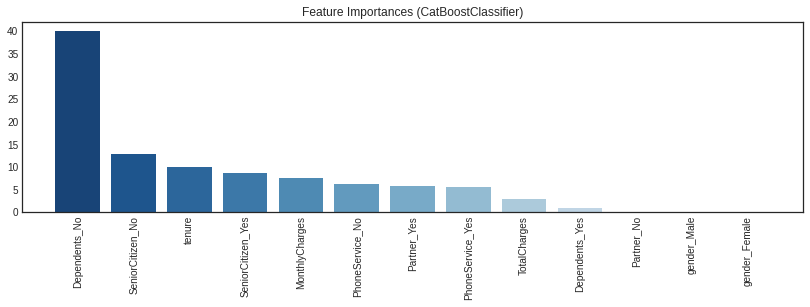

In [47]:
cb_clf.fit(X_train, y_train)
plot_feature_importances(cb_clf)

## <a id='6.3'>6.3 Testing other classification algorithms</a>

### <a id='6.3.1'>6.3.1 KNeighbors</a>

In [48]:
# Finding the best K
Ks = 60
rec = []
for k in range(1, Ks):
    knn = kNN(n_neighbors=k, metric='minkowski')
    knn.fit(X_train, y_train)
    knn_yhat = knn.predict(X_test)
    rec.append((k, recall_score(y_test, knn_yhat)))
best_k = sorted(rec, key=lambda x:x[1], reverse=True)[0][0]
print("Best K is", best_k)

Best K is 15


In [51]:
# Train with the best K
knn = kNN(n_neighbors=best_k, metric='minkowski')
scores = val_kfold(knn)
show_scores(scores)

CV Recall: 0.51 +/- 0.048
CV ROC AUC: 0.82 +/- 0.016


In [52]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

### <a id='6.3.2'>6.3.2 SVM</a>

In [53]:
svm = SVC(kernel='rbf', C=0.01, 
          class_weight='balanced', random_state=1)
scores = val_kfold(svm)
show_scores(scores)

CV Recall: 0.80 +/- 0.028
CV ROC AUC: 0.83 +/- 0.012


In [54]:
svm.fit(X_train, y_train)

SVC(C=0.01, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='rbf', max_iter=-1, probability=False, random_state=1,
    shrinking=True, tol=0.001, verbose=False)

### <a id='6.3.3'>6.3.3 Logistic Regression</a>

In [55]:
lr = LogisticRegression(penalty='l2', C=0.01,
                        class_weight='balanced',
                        random_state=1)
scores = val_kfold(lr)
show_scores(scores)

CV Recall: 0.79 +/- 0.029
CV ROC AUC: 0.84 +/- 0.013


In [56]:
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### <a id='6.3.4'>6.3.4 Naive Bayes</a>

In [57]:
bnb = BernoulliNB()
scores = val_kfold(bnb)
show_scores(scores)
bnb.fit(X_train, y_train)

CV Recall: 0.74 +/- 0.030
CV ROC AUC: 0.83 +/- 0.013


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

# <a id='7.0'>7.0 Model Evaluation and Results</a>

## <a id='7.1'>7.1 Table of Scores</a>

In [61]:
models = [xgb_clf, lgb_clf, cb_clf, RF_clf, knn, svm, lr, bnb]
f1score = [f1_score(y_test, model.predict(X_test)) for model in models]
rec = [recall_score(y_test, model.predict(X_test)) for model in models]
pre = [precision_score(y_test, model.predict(X_test)) for model in models]
bal_acc = [balanced_accuracy_score(y_test, model.predict(X_test)) for model in models]
roc_auc = [roc_auc_score(y_test, model.predict(X_test)) for model in models]

df_results = pd.DataFrame({"Algorithm" : [type(model).__name__ for model in models],
                           "Balanced Acc" : bal_acc,
                           "Recall" : rec,
                           "Precision" : pre,
                           "F1-Score" : f1score,
                           "ROC AUC" : roc_auc})
pd.options.display.float_format = '{:,.2f}'.format
df_results

,Algorithm,Balanced Acc,Recall,Precision,F1-Score,ROC AUC
0,XGBClassifier,0.76,0.73,0.57,0.64,0.76
1,LGBMClassifier,0.76,0.72,0.57,0.63,0.76
2,CatBoostClassifier,0.77,0.75,0.55,0.64,0.77
3,RandomForestClassifier,0.77,0.77,0.55,0.64,0.77
4,KNeighborsClassifier,0.71,0.53,0.61,0.57,0.71
5,SVC,0.76,0.80,0.51,0.62,0.76
6,LogisticRegression,0.77,0.80,0.52,0.63,0.77
7,BernoulliNB,0.76,0.75,0.53,0.62,0.76


## <a id='7.2'>7.2 Comparing Performances</a>

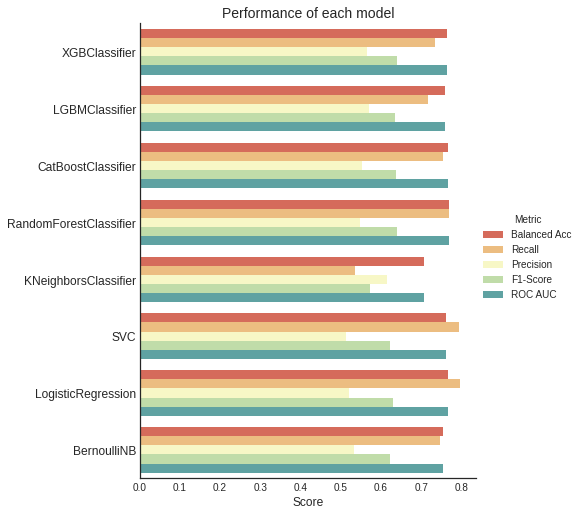

In [62]:
df_scores = df_results.set_index('Algorithm').stack()\
                      .rename_axis(['Algorithm', 'Metric'])\
                      .reset_index(name='Score')
                                 
sns.catplot(x="Score", 
            y='Algorithm',
            hue='Metric', 
            data=df_scores,
            height=7,
            kind='bar',
            palette="Spectral")
plt.ylabel(None)
plt.xlabel("Score", size=12)
plt.yticks(size=12)
plt.title("Performance of each model", size=14)
plt.show()

Because we trained and evaluated our models using an imbalanced dataset, standard predictive accuracy is not an appropriate metric to assess the quality of our models. Here we used *balanced accuracy*, a measure of accuracy for the imbalanced class scenario, defined as the average of recall obtained on each class. But we are more interested in predict whether a particular customer will churn. For this purpose, recall is a reasonable metric, because it is a measure of the true positive rate: the proportion of samples the algorithm correctly classified as being of the positive class. Logistic Regression and SVM algorithms achieved the best recall score. However, as shown below in the confusion matrices, they also misclassified some examples from the positive class. One reason for this rate of misclassification, is the existence of overlapping samples around the borderline zone in feature space, where the two classes are separeted.

&nbsp;

We also must pay special attention to the ROC AUC score. The higher the AUC score, the better our model is at correctly predicting the classes. If I were to choose one model from the above list, it would be logistic regression, because of its high recall and good AUC score.

## <a id='7.3'>7.3 Confusion Matrix</a>

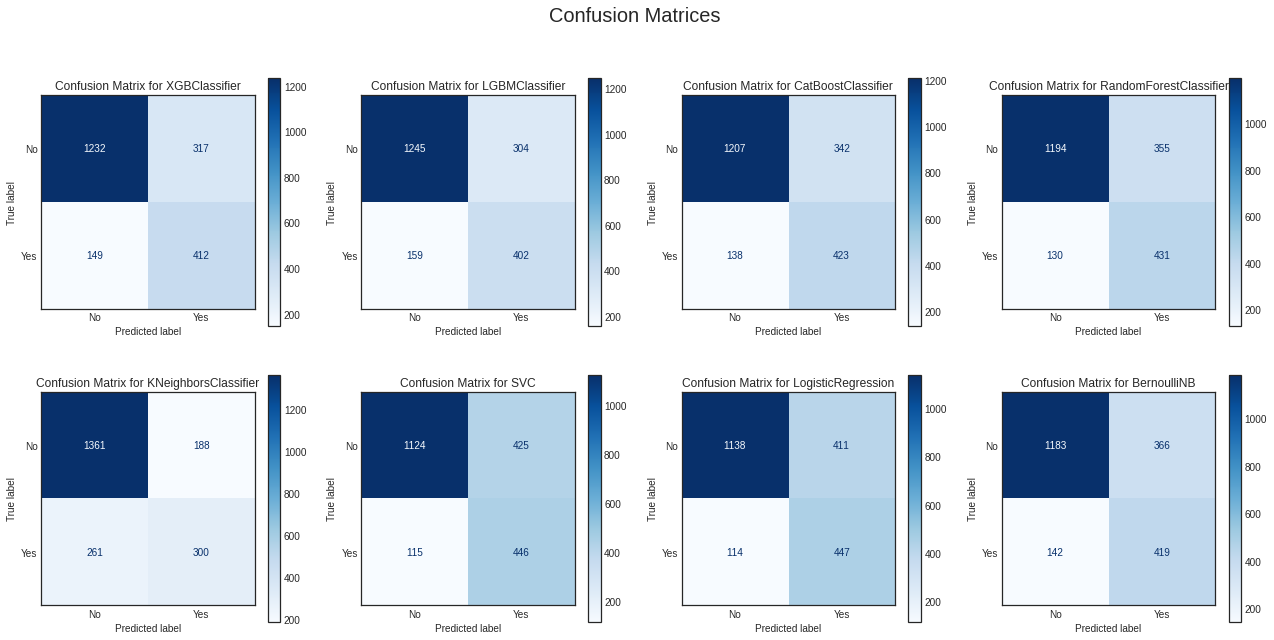

In [63]:
fig, ax = plt.subplots(2, 4, figsize=(22, 10))
fig.suptitle("Confusion Matrices", size=20)
for model, axes in zip(models, ax.flatten()):
    cm = plot_confusion_matrix(model, X_test, y_test,
                               display_labels=['No', 'Yes'],
                               cmap="Blues",
                               normalize=None,
                               values_format='.10g',
                               ax=axes)
    cm.ax_.set_title("Confusion Matrix for {}".format(type(model).__name__))
plt.show()

## <a id='7.4'>7.4 ROC Curves</a>

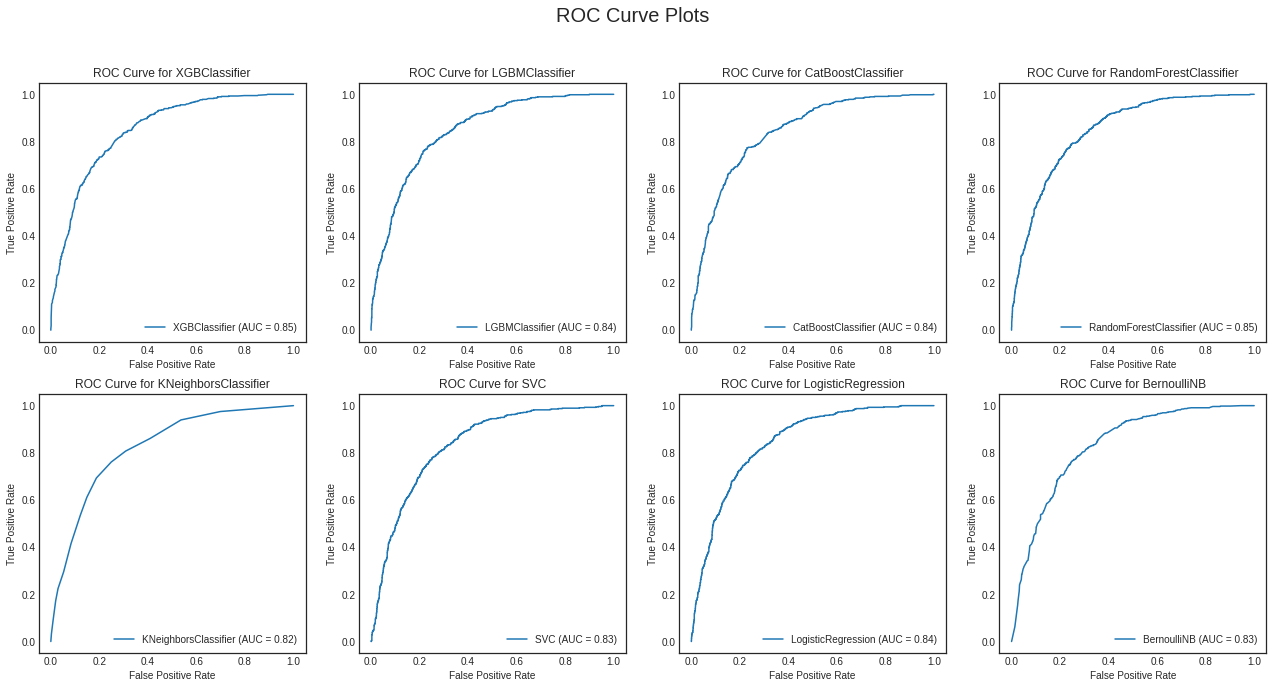

In [64]:
fig, ax = plt.subplots(2, 4, figsize=(22, 10.5))
fig.suptitle("ROC Curve Plots", size=20)
for model, axes in zip(models, ax.flatten()):
    rocc = plot_roc_curve(model, X_test, y_test, ax=axes)
    rocc.ax_.set_title("ROC Curve for {}".format(type(model).__name__))
plt.show()

# <a id='8.0'>8.0 Dealing with Class Imbalance</a>

In this section, we address the problem of class imbalance, with oversampling strategies of the minority class. We will train logistic regression algorithm on the resampled training data.

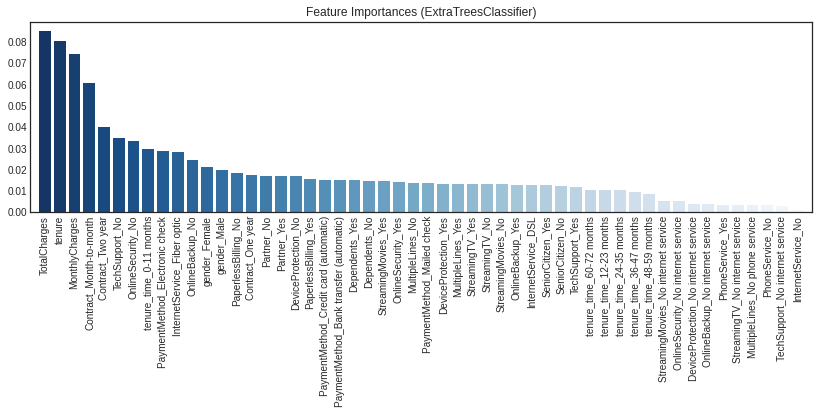

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_true, test_size=.3, 
                                                    random_state=111, stratify=y_true)

# Feature selection Procedure
clf = ExtraTreesClassifier(n_estimators=50,
                           class_weight='balanced')
clf.fit(X_train, y_train)
plot_feature_importances(clf)
model = SelectFromModel(clf, prefit=True)
X_train, X_test = model.transform(X_train), model.transform(X_test)

In [0]:
def pipe_logreg(oversamplewith=None):
    kfold = StratifiedKFold(n_splits=10, random_state=1)
  
    lr_pipe = make_pipeline(oversamplewith,
                            StandardScaler(),
                            LogisticRegression(penalty='l2', C=2,
                                               random_state=1))
  
    scores = cross_validate(lr_pipe, X_train, y_train, 
                            scoring=['recall', 'roc_auc'], cv=kfold, n_jobs=-1)
    return lr_pipe, scores 

## <a id='8.1'>8.1 Oversampling with SMOTE</a>

In [95]:
lr_smote, scores = pipe_logreg(oversamplewith=SMOTE(sampling_strategy=0.8))
show_scores(scores)

CV Recall: 0.77 +/- 0.031
CV ROC AUC: 0.84 +/- 0.012


In [96]:
lr_smote.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=None, ratio=None,
                       sampling_strategy=0.8, svm_estimator='deprecated')),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=2, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=1,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

## <a id='8.2'>8.2 Oversampling with BorderlineSMOTE</a>

In [97]:
lr_blsmote, scores = pipe_logreg(oversamplewith=BorderlineSMOTE(sampling_strategy=0.8, n_jobs=-1))
show_scores(scores)

CV Recall: 0.79 +/- 0.022
CV ROC AUC: 0.84 +/- 0.012


In [98]:
lr_blsmote.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('borderlinesmote',
                 BorderlineSMOTE(k_neighbors=5, kind='borderline-1',
                                 m_neighbors=10, n_jobs=-1, random_state=None,
                                 sampling_strategy=0.8)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=2, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=1,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

## <a id='8.3'>8.3 Oversampling with SVMSMOTE</a>

In [99]:
lr_svmsmote, scores = pipe_logreg(oversamplewith=SVMSMOTE(sampling_strategy=0.8))
show_scores(scores)

CV Recall: 0.76 +/- 0.035
CV ROC AUC: 0.84 +/- 0.012


In [100]:
lr_svmsmote.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('svmsmote',
                 SVMSMOTE(k_neighbors=5, m_neighbors=10, n_jobs=1, out_step=0.5,
                          random_state=None, sampling_strategy=0.8,
                          svm_estimator=None)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=2, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=1,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

## <a id='8.4'>8.4 Evaluation</a>

In [101]:
pipe_name = ["Log Regression (SMOTE)", "Log Regression (BorderLineSMOTE)", "Log Regression (SVMSMOTE)"]
models = [lr_smote, lr_blsmote, lr_svmsmote]
f1score = [f1_score(y_test, model.predict(X_test)) for model in models]
rec = [recall_score(y_test, model.predict(X_test)) for model in models]
pre = [precision_score(y_test, model.predict(X_test)) for model in models]
acc = [accuracy_score(y_test, model.predict(X_test)) for model in models]
roc_auc = [roc_auc_score(y_test, model.predict(X_test)) for model in models]

df_results = pd.DataFrame({"Algorithm" : pipe_name,
                           "Accuracy" : acc,
                           "Recall" : rec,
                           "Precision" : pre,
                           "F1-Score" : f1score,
                           "ROC AUC" : roc_auc})
pd.options.display.float_format = '{:,.2f}'.format
df_results

,Algorithm,Accuracy,Recall,Precision,F1-Score,ROC AUC
0,Log Regression (SMOTE),0.77,0.76,0.54,0.63,0.76
1,Log Regression (BorderLineSMOTE),0.75,0.79,0.52,0.63,0.76
2,Log Regression (SVMSMOTE),0.77,0.75,0.55,0.64,0.77


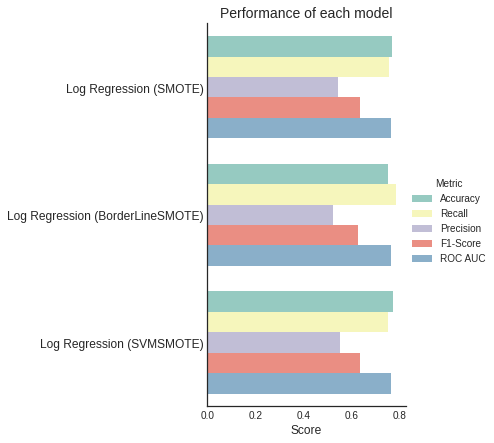

In [102]:
df_scores = df_results.set_index('Algorithm').stack()\
                      .rename_axis(['Algorithm', 'Metric'])\
                      .reset_index(name='Score')
                                 
sns.catplot(x="Score", 
            y='Algorithm',
            hue='Metric', 
            data=df_scores,
            height=6,
            kind='bar',
            palette="Set3")
plt.ylabel(None)
plt.xlabel("Score", size=12)
plt.yticks(size=12)
plt.title("Performance of each model", size=14)
plt.show()

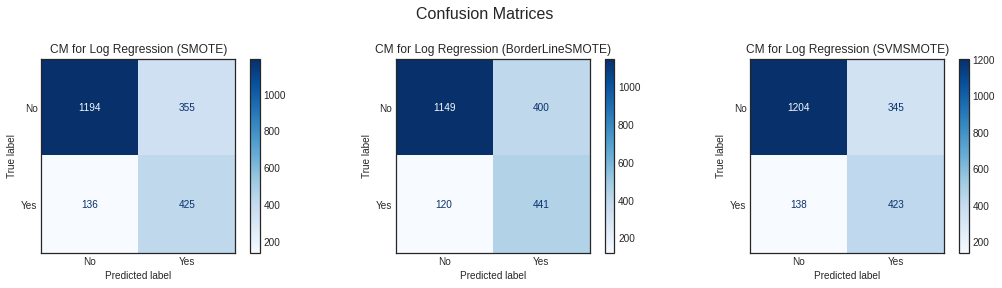

In [103]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
fig.suptitle("Confusion Matrices", size=16)
for model, axes, names in zip(models, ax.flatten(), pipe_name):
    cm = plot_confusion_matrix(model, X_test, y_test,
                             display_labels=['No', 'Yes'],
                             cmap="Blues",
                             normalize=None,
                             values_format='.10g',
                             ax=axes)
    cm.ax_.set_title("CM for {}".format(names))
plt.subplots_adjust(top=0.8)
plt.show()